In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import execute, Aer
from circuits import RepetitionCode
from fitters import GraphDecoder, lookuptable_decoding, postselection_decoding

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_model


In [3]:
def get_syndrome(code,noise_model,shots=1014):
    circuits = code.get_circuit_list()
    job = execute( circuits, Aer.get_backend('qasm_simulator'),noise_model=noise_model, shots=shots )
    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(log)

    return raw_results

In [4]:
def plot_qubit_probs(raw_res_dict, shots=4096):
    # get "probability of 1" for logical 0 
    for log in ["0", "1"]:
        all_occurances = list(raw_res_dict[log].keys())
        occurance_counts = list(raw_res_dict[log].values())
        ar = [list(x.replace(" ", "")) for x in all_occurances]
        dat = pd.DataFrame(ar)
        dat["counts"] = pd.Series(occurance_counts)
        qbitnum_prob = []
        qbitnum_prob.append((dat.loc[(dat[0]=="1")]["counts"]).sum()/shots)
        for i in range(d):
            qbitnum_prob.append((dat.loc[(dat[i+d]=="1")]["counts"]).sum()/shots)
            qbitnum_prob.append((dat.loc[(dat[i]=="1")]["counts"]).sum()/shots)
        qbitnum_prob_map = {k:v for k,v in enumerate(qbitnum_prob)}
        print(qbitnum_prob_map)
        plt.plot(list(qbitnum_prob_map.values()), '-^')
    plt.show()
    # get "probability of 1" for logical 1

In [5]:
def get_logical_prob(empty_code):
    raw_results = get_syndrome(empty_code,noise_model=noise_model,shots=8192)
    results = empty_code.process_results(raw_results)

    dec = GraphDecoder(empty_code)

    logical_prob_match = dec.get_logical_prob(results)
    logical_prob_lookup = lookuptable_decoding(results,results)
    logical_prob_post = postselection_decoding(results)

    return logical_prob_match['0'], logical_prob_match['1']

{0: 0.079345703125, 1: 0.1689453125, 2: 0.079345703125, 3: 0.075439453125, 4: 0.077880859375}
{0: 0.92578125, 1: 0.169921875, 2: 0.92578125, 3: 0.080078125, 4: 0.916259765625}


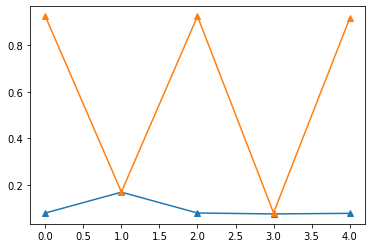

In [6]:
# d = 8
T = 2
for d in range(2,9):
    empty_code = RepetitionCode(d,T)
    noise_model = get_noise(0.04,0.04)
    raw_results = get_syndrome(empty_code, noise_model, shots=4096)
    plot_qubit_probs(raw_results, shots=4096)
    get_logical_prob(empty_code)